In [4]:
%load_ext autoreload
%autoreload 2

In [2]:
!git pull

Already up to date.


In [3]:
! pip install mlflow transformers datasets "pydantic[dotenv]" av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 77.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 54.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.7/232.7 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.

In [5]:
import mlflow
from mlflow.client import MlflowClient
import pandas as pd
import os
import matplotlib.pyplot as plt
from overfit.env_settings import settings
from overfit.utils.mlflow import get_all_experiments, get_params_from_experiment_name
import numpy as np
import itertools
from tqdm.notebook import tqdm


In [6]:
assert settings.MLFLOW_TRACKING_URI


In [7]:
client = MlflowClient(tracking_uri=settings.MLFLOW_TRACKING_URI)


In [8]:
ALL_CONFIDENCES = [0.1, 0.2, 0.3, 0.9]
ALL_WEIGHT_DECAYS = [0.1, 0.2, 0.3, 0.4]
ALL_MAX_LRS = [0.1, 0.2, 0.3, 0.4]
ALL_DATSETS = ["4-50", "5-50", "6-75"]
MODELS = ["resnet18", "resnet34", "resnet50", "vit"]


In [9]:
CONFIDENCES = [0.1]
WEIGHT_DECAYS = [0.2]
MAX_LRS = [0.4]
MOMENTUMS = [0.1]
DATASETS = ["4-50", "5-50", "6-75"]
MODELS = ["resnet18", "resnet34", "resnet50", "vit"]

EXPERIMENT_NAMES = get_all_experiments(
    datasets=DATASETS,
    models=MODELS,
    confidences=CONFIDENCES,
    weight_decays=WEIGHT_DECAYS,
    max_lrs=MAX_LRS,
    momentums=MOMENTUMS,
)
EXPERIMENT_NAMES


['D4-50Mresnet18C0.1WD0.2LR0.4M0.1',
 'D4-50Mresnet34C0.1WD0.2LR0.4M0.1',
 'D4-50Mresnet50C0.1WD0.2LR0.4M0.1',
 'D4-50MvitC0.1WD0.2LR0.4M0.1',
 'D5-50Mresnet18C0.1WD0.2LR0.4M0.1',
 'D5-50Mresnet34C0.1WD0.2LR0.4M0.1',
 'D5-50Mresnet50C0.1WD0.2LR0.4M0.1',
 'D5-50MvitC0.1WD0.2LR0.4M0.1',
 'D6-75Mresnet18C0.1WD0.2LR0.4M0.1',
 'D6-75Mresnet34C0.1WD0.2LR0.4M0.1',
 'D6-75Mresnet50C0.1WD0.2LR0.4M0.1',
 'D6-75MvitC0.1WD0.2LR0.4M0.1']

In [10]:
experiments = [
    client.get_experiment_by_name(experiment_name)
    for experiment_name in tqdm(EXPERIMENT_NAMES)
]


  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
experiments


In [ ]:
def get_experiment_error_df(experiment_id: str) -> pd.DataFrame:
    src_errors = []
    tgt_errors = []
    pimps = []
    mean_entropies = []
    runs = client.search_runs(experiment_ids=[experiment_id])
    for run in tqdm(runs):
        N = int(run.data.params["Frames"])
        filename = run.data.params["Filename"]
        src_acc_top1 = run.data.metrics["Source Accumulated Top-1 Count"]
        tgt_acc_top1 = run.data.metrics["Target Accumulated Top-1 Count"]
        src_error = 100 * (N - src_acc_top1) / N
        tgt_error = 100 * (N - tgt_acc_top1) / N
        pimp = 100 * (tgt_error - src_error) / (src_error) if src_error != 0 else 0
        assert src_error >= 0, (src_error, src_acc_top1, N, filename)
        assert tgt_error >= 0, (tgt_error, tgt_acc_top1, N, filename)
        pimps.append(pimp)
        src_errors.append(src_error)
        tgt_errors.append(tgt_error)
        # mean_entropies.append(mean_entropy)

    df = pd.DataFrame(
        {
            "Source Error": src_errors,
            "Target Error": tgt_errors,
            # "Mean Source Entropy": mean_entropies,
        }
    )
    return df.describe()


In [ ]:
dfs = [
    get_experiment_error_df(experiment.experiment_id)
    for experiment in tqdm(experiments)
]


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

In [ ]:
def get_experiment_entropy_df(experiment_id: str) -> pd.DataFrame:
    mean_correct_entropies = []
    mean_incorrect_entropies = []
    mean_entropies = []
    runs = client.search_runs(experiment_ids=[experiment_id])
    for run in tqdm(runs):
        N = int(run.data.params["Frames"])
        entropy_metrics = client.get_metric_history(
            run.info.run_id, "Source Prediction Entropy"
        )
        rank_metrics = client.get_metric_history(run.info.run_id, "Source Correct Rank")

        correct_entropies = []
        incorrect_entropies = []
        for entropy_metric, rank_metric in zip(entropy_metrics, rank_metrics):
            if rank_metric.value == 0:
                correct_entropies.append(entropy_metric.value)
            else:
                incorrect_entropies.append(entropy_metric.value)

        mean_correct_entropy = (
            sum(correct_entropies) / len(correct_entropies)
            if len(correct_entropies)
            else np.nan
        )
        mean_incorrect_entropy = (
            sum(incorrect_entropies) / len(incorrect_entropies)
            if len(incorrect_entropies)
            else np.nan
        )
        mean_correct_entropies.append(mean_correct_entropy)
        mean_incorrect_entropies.append(mean_incorrect_entropy)
        mean_entropies.append(sum(correct_entropies + incorrect_entropies) / N)

    df = pd.DataFrame(
        {
            "Mean Source Entropy": mean_entropies,
            "Mean Source Correct Entropy": mean_correct_entropies,
            "Mean Source Incorrect Entropy": mean_incorrect_entropies,
        }
    )
    return df


In [20]:
h_dfs = [
    get_experiment_entropy_df(experiment.experiment_id)
    for experiment in tqdm(experiments[:4])
]


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

In [23]:
[exp.name for exp in experiments[:4]]


['D4-50Mresnet18C0.1WD0.2LR0.4M0.1',
 'D4-50Mresnet34C0.1WD0.2LR0.4M0.1',
 'D4-50Mresnet50C0.1WD0.2LR0.4M0.1',
 'D4-50MvitC0.1WD0.2LR0.4M0.1']

In [24]:
mean_h_df = pd.concat([df.describe().loc["mean"] for df in h_dfs], axis=1).T
mean_h_df = mean_h_df.set_axis(
    [experiment.name for experiment in experiments[:4]], axis=0
).dropna()
mean_h_df


,Mean Source Entropy,Mean Source Correct Entropy,Mean Source Incorrect Entropy
D4-50Mresnet18C0.1WD0.2LR0.4M0.1,0.511973,0.336634,0.574240
D4-50Mresnet34C0.1WD0.2LR0.4M0.1,0.474957,0.301109,0.553268
D4-50Mresnet50C0.1WD0.2LR0.4M0.1,0.452796,0.273537,0.543486
D4-50MvitC0.1WD0.2LR0.4M0.1,0.464513,0.322150,0.583000


In [26]:
std_h_df = pd.concat([df.describe().loc["std"] for df in h_dfs], axis=1).T
std_h_df = std_h_df.set_axis(
    [experiment.name for experiment in experiments[:4]], axis=0
).dropna()
std_h_df


,Mean Source Entropy,Mean Source Correct Entropy,Mean Source Incorrect Entropy
D4-50Mresnet18C0.1WD0.2LR0.4M0.1,0.117930,0.152835,0.101804
D4-50Mresnet34C0.1WD0.2LR0.4M0.1,0.118289,0.149328,0.104306
D4-50Mresnet50C0.1WD0.2LR0.4M0.1,0.126032,0.148581,0.116698
D4-50MvitC0.1WD0.2LR0.4M0.1,0.104384,0.103923,0.104411


In [27]:
mean_h_df.to_csv("mean_h_df.csv")
std_h_df.to_csv("std_h_df.csv")



In [ ]:
experiment_names = [experiment.name for experiment in experiments]


In [ ]:
params_df = pd.DataFrame(
    [
        get_params_from_experiment_name(experiment_name)
        for experiment_name in experiment_names
    ],
    index=experiment_names,
)
params_df


,dataset,model,confidence,weight_decay,max_lr,momentum
D4-50Mresnet18C0.1WD0.2LR0.4M0.1,4-50,resnet18,0.1,0.2,0.4,0.1
D4-50Mresnet34C0.1WD0.2LR0.4M0.1,4-50,resnet34,0.1,0.2,0.4,0.1
D4-50Mresnet50C0.1WD0.2LR0.4M0.1,4-50,resnet50,0.1,0.2,0.4,0.1
D4-50MvitC0.1WD0.2LR0.4M0.1,4-50,vit,0.1,0.2,0.4,0.1
D5-50Mresnet18C0.1WD0.2LR0.4M0.1,5-50,resnet18,0.1,0.2,0.4,0.1
D5-50Mresnet34C0.1WD0.2LR0.4M0.1,5-50,resnet34,0.1,0.2,0.4,0.1
D5-50Mresnet50C0.1WD0.2LR0.4M0.1,5-50,resnet50,0.1,0.2,0.4,0.1
D5-50MvitC0.1WD0.2LR0.4M0.1,5-50,vit,0.1,0.2,0.4,0.1
D6-75Mresnet18C0.1WD0.2LR0.4M0.1,6-75,resnet18,0.1,0.2,0.4,0.1
D6-75Mresnet34C0.1WD0.2LR0.4M0.1,6-75,resnet34,0.1,0.2,0.4,0.1


In [ ]:
mean_df = pd.concat([df.loc["mean"] for df in dfs], axis=1).T
mean_df = mean_df.set_axis(
    [experiment.name for experiment in experiments], axis=0
).dropna()
mean_df = mean_df.rename(
    columns={"Source Error": "Source Error Mean", "Target Error": "Target Error Mean"}
)
mean_df_base = mean_df[["Source Error Mean", "Target Error Mean"]]
mean_df


,Source Error Mean,Target Error Mean
D4-50Mresnet18C0.1WD0.2LR0.4M0.1,77.693508,73.605393
D4-50Mresnet34C0.1WD0.2LR0.4M0.1,73.518409,69.038636
D4-50Mresnet50C0.1WD0.2LR0.4M0.1,70.920268,66.307982
D4-50MvitC0.1WD0.2LR0.4M0.1,59.351015,53.890648
D5-50Mresnet18C0.1WD0.2LR0.4M0.1,85.229688,81.513781
D5-50Mresnet34C0.1WD0.2LR0.4M0.1,81.950797,77.586133
D5-50Mresnet50C0.1WD0.2LR0.4M0.1,80.416532,76.397286
D5-50MvitC0.1WD0.2LR0.4M0.1,69.764074,64.149530
D6-75Mresnet18C0.1WD0.2LR0.4M0.1,90.175448,87.877753
D6-75Mresnet34C0.1WD0.2LR0.4M0.1,87.726005,85.037361


In [ ]:
mean_df["Error Mean Percent Change"] = (
    100
    * (mean_df["Target Error Mean"] - mean_df["Source Error Mean"])
    / mean_df["Source Error Mean"]
)
# mean_df["Error Mean Absolute Change"] = mean_df["Target Error Mean"] - mean_df["Source Error Mean"]
mean_df_change = mean_df[["Error Mean Percent Change", "Error Mean Absolute Change"]]
mean_df


,Source Error Mean,Target Error Mean,Error Mean Percentual Change,Error Mean Absolute Change
D4-50Mresnet18C0.1WD0.2LR0.4M0.1,77.693508,73.605393,-5.261849,-4.088115
D4-50Mresnet34C0.1WD0.2LR0.4M0.1,73.518409,69.038636,-6.093403,-4.479773
D4-50Mresnet50C0.1WD0.2LR0.4M0.1,70.920268,66.307982,-6.503480,-4.612286
D4-50MvitC0.1WD0.2LR0.4M0.1,59.351015,53.890648,-9.200124,-5.460367
D5-50Mresnet18C0.1WD0.2LR0.4M0.1,85.229688,81.513781,-4.359874,-3.715907
D5-50Mresnet34C0.1WD0.2LR0.4M0.1,81.950797,77.586133,-5.325957,-4.364664
D5-50Mresnet50C0.1WD0.2LR0.4M0.1,80.416532,76.397286,-4.998034,-4.019246
D5-50MvitC0.1WD0.2LR0.4M0.1,69.764074,64.149530,-8.047901,-5.614544
D6-75Mresnet18C0.1WD0.2LR0.4M0.1,90.175448,87.877753,-2.548027,-2.297695
D6-75Mresnet34C0.1WD0.2LR0.4M0.1,87.726005,85.037361,-3.064819,-2.688644


In [ ]:
std_df = pd.concat([df.loc["std"] for df in dfs], axis=1).T
std_df = std_df.set_axis(
    [experiment.name for experiment in experiments], axis=0
).dropna()
std_df = std_df.rename(
    columns={"Source Error": "Source Error Std", "Target Error": "Target Error Std"}
)
std_df_base = std_df[["Source Error Std", "Target Error Std"]]
std_df


,Source Error Std,Target Error Std
D4-50Mresnet18C0.1WD0.2LR0.4M0.1,19.900635,23.913133
D4-50Mresnet34C0.1WD0.2LR0.4M0.1,21.373525,25.182403
D4-50Mresnet50C0.1WD0.2LR0.4M0.1,21.822556,25.211179
D4-50MvitC0.1WD0.2LR0.4M0.1,23.749646,26.057293
D5-50Mresnet18C0.1WD0.2LR0.4M0.1,15.937854,20.437132
D5-50Mresnet34C0.1WD0.2LR0.4M0.1,17.297296,22.294831
D5-50Mresnet50C0.1WD0.2LR0.4M0.1,18.113544,22.240806
D5-50MvitC0.1WD0.2LR0.4M0.1,21.067119,24.815788
D6-75Mresnet18C0.1WD0.2LR0.4M0.1,13.409268,17.307979
D6-75Mresnet34C0.1WD0.2LR0.4M0.1,14.421175,18.667371


In [ ]:
std_df["Error Std Percent Change"] = (
    100
    * (std_df["Target Error Std"] - std_df["Source Error Std"])
    / std_df["Source Error Std"]
)
# std_df["Error Std Absolute Change"] = std_df["Target Error Std"] - std_df["Source Error Std"]
std_df_change = std_df[["Error Std Percent Change", "Error Std Absolute Change"]]
std_df


KeyError: "['Error Std Absolute Change'] not in index"

In [ ]:
mean_df.join(std_df)


,Source Error Mean,Target Error Mean,Error Mean Percentual Change,Error Mean Absolute Change,Source Error Std,Target Error Std,Error Std Percentual Change,Error Std Absolute Change
D4-50Mresnet18C0.1WD0.2LR0.4M0.1,77.693508,73.605393,-5.261849,-4.088115,19.900635,23.913133,20.162667,4.012499
D4-50Mresnet34C0.1WD0.2LR0.4M0.1,73.518409,69.038636,-6.093403,-4.479773,21.373525,25.182403,17.820542,3.808878
D4-50Mresnet50C0.1WD0.2LR0.4M0.1,70.920268,66.307982,-6.503480,-4.612286,21.822556,25.211179,15.528073,3.388622
D4-50MvitC0.1WD0.2LR0.4M0.1,59.351015,53.890648,-9.200124,-5.460367,23.749646,26.057293,9.716553,2.307647
D5-50Mresnet18C0.1WD0.2LR0.4M0.1,85.229688,81.513781,-4.359874,-3.715907,15.937854,20.437132,28.230138,4.499278
D5-50Mresnet34C0.1WD0.2LR0.4M0.1,81.950797,77.586133,-5.325957,-4.364664,17.297296,22.294831,28.892003,4.997535
D5-50Mresnet50C0.1WD0.2LR0.4M0.1,80.416532,76.397286,-4.998034,-4.019246,18.113544,22.240806,22.785502,4.127262
D5-50MvitC0.1WD0.2LR0.4M0.1,69.764074,64.149530,-8.047901,-5.614544,21.067119,24.815788,17.793932,3.748669
D6-75Mresnet18C0.1WD0.2LR0.4M0.1,90.175448,87.877753,-2.548027,-2.297695,13.409268,17.307979,29.074747,3.898711
D6-75Mresnet34C0.1WD0.2LR0.4M0.1,87.726005,85.037361,-3.064819,-2.688644,14.421175,18.667371,29.444182,4.246197


In [ ]:
all_df = params_df[["model", "dataset"]].join(mean_df).join(std_df)
all_df


,model,dataset,Source Error Mean,Target Error Mean,Error Mean Percentual Change,Error Mean Absolute Change,Source Error Std,Target Error Std,Error Std Percentual Change
D4-50Mresnet18C0.1WD0.2LR0.4M0.1,resnet18,4-50,77.693508,73.605393,-5.261849,-4.088115,19.900635,23.913133,20.162667
D4-50Mresnet34C0.1WD0.2LR0.4M0.1,resnet34,4-50,73.518409,69.038636,-6.093403,-4.479773,21.373525,25.182403,17.820542
D4-50Mresnet50C0.1WD0.2LR0.4M0.1,resnet50,4-50,70.920268,66.307982,-6.503480,-4.612286,21.822556,25.211179,15.528073
D4-50MvitC0.1WD0.2LR0.4M0.1,vit,4-50,59.351015,53.890648,-9.200124,-5.460367,23.749646,26.057293,9.716553
D5-50Mresnet18C0.1WD0.2LR0.4M0.1,resnet18,5-50,85.229688,81.513781,-4.359874,-3.715907,15.937854,20.437132,28.230138
D5-50Mresnet34C0.1WD0.2LR0.4M0.1,resnet34,5-50,81.950797,77.586133,-5.325957,-4.364664,17.297296,22.294831,28.892003
D5-50Mresnet50C0.1WD0.2LR0.4M0.1,resnet50,5-50,80.416532,76.397286,-4.998034,-4.019246,18.113544,22.240806,22.785502
D5-50MvitC0.1WD0.2LR0.4M0.1,vit,5-50,69.764074,64.149530,-8.047901,-5.614544,21.067119,24.815788,17.793932
D6-75Mresnet18C0.1WD0.2LR0.4M0.1,resnet18,6-75,90.175448,87.877753,-2.548027,-2.297695,13.409268,17.307979,29.074747
D6-75Mresnet34C0.1WD0.2LR0.4M0.1,resnet34,6-75,87.726005,85.037361,-3.064819,-2.688644,14.421175,18.667371,29.444182


In [ ]:
all_df_base = params_df[["model", "dataset"]].join(mean_df_base).join(std_df_base)
all_df_base


,model,dataset,Source Error Mean,Target Error Mean,Source Error Std,Target Error Std
D4-50Mresnet18C0.1WD0.2LR0.4M0.1,resnet18,4-50,77.693508,73.605393,19.900635,23.913133
D4-50Mresnet34C0.1WD0.2LR0.4M0.1,resnet34,4-50,73.518409,69.038636,21.373525,25.182403
D4-50Mresnet50C0.1WD0.2LR0.4M0.1,resnet50,4-50,70.920268,66.307982,21.822556,25.211179
D4-50MvitC0.1WD0.2LR0.4M0.1,vit,4-50,59.351015,53.890648,23.749646,26.057293
D5-50Mresnet18C0.1WD0.2LR0.4M0.1,resnet18,5-50,85.229688,81.513781,15.937854,20.437132
D5-50Mresnet34C0.1WD0.2LR0.4M0.1,resnet34,5-50,81.950797,77.586133,17.297296,22.294831
D5-50Mresnet50C0.1WD0.2LR0.4M0.1,resnet50,5-50,80.416532,76.397286,18.113544,22.240806
D5-50MvitC0.1WD0.2LR0.4M0.1,vit,5-50,69.764074,64.149530,21.067119,24.815788
D6-75Mresnet18C0.1WD0.2LR0.4M0.1,resnet18,6-75,90.175448,87.877753,13.409268,17.307979
D6-75Mresnet34C0.1WD0.2LR0.4M0.1,resnet34,6-75,87.726005,85.037361,14.421175,18.667371


In [ ]:
all_df_change = params_df[["model", "dataset"]].join(mean_df_change).join(std_df_change)
all_df_change


,model,dataset,Error Mean Percentual Change,Error Mean Absolute Change,Error Std Percentual Change,Error Std Absolute Change
D4-50Mresnet18C0.1WD0.2LR0.4M0.1,resnet18,4-50,-5.261849,-4.088115,20.162667,4.012499
D4-50Mresnet34C0.1WD0.2LR0.4M0.1,resnet34,4-50,-6.093403,-4.479773,17.820542,3.808878
D4-50Mresnet50C0.1WD0.2LR0.4M0.1,resnet50,4-50,-6.503480,-4.612286,15.528073,3.388622
D4-50MvitC0.1WD0.2LR0.4M0.1,vit,4-50,-9.200124,-5.460367,9.716553,2.307647
D5-50Mresnet18C0.1WD0.2LR0.4M0.1,resnet18,5-50,-4.359874,-3.715907,28.230138,4.499278
D5-50Mresnet34C0.1WD0.2LR0.4M0.1,resnet34,5-50,-5.325957,-4.364664,28.892003,4.997535
D5-50Mresnet50C0.1WD0.2LR0.4M0.1,resnet50,5-50,-4.998034,-4.019246,22.785502,4.127262
D5-50MvitC0.1WD0.2LR0.4M0.1,vit,5-50,-8.047901,-5.614544,17.793932,3.748669
D6-75Mresnet18C0.1WD0.2LR0.4M0.1,resnet18,6-75,-2.548027,-2.297695,29.074747,3.898711
D6-75Mresnet34C0.1WD0.2LR0.4M0.1,resnet34,6-75,-3.064819,-2.688644,29.444182,4.246197


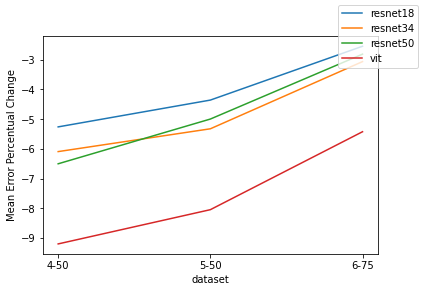

In [ ]:
mddf = all_df.sort_values(["model", "dataset"])
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("dataset")
ax.set_ylabel("Mean Error Percent Change")
for idx, group in mddf.groupby("model"):
    ax.plot(group["dataset"], group["Mean Error Percent Change"], label=idx)

fig.legend()


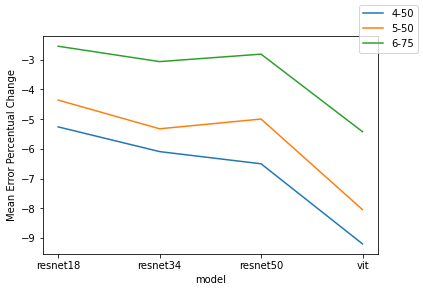

In [ ]:
dmdf = all_df.sort_values(["dataset", "model"])
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("model")
ax.set_ylabel("Mean Error Percent Change")
for idx, group in dmdf.groupby("dataset"):
    ax.plot(group["model"], group["Mean Error Percent Change"], label=idx)

fig.legend()
